In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 


In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col]) 
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
            i += 1
        return df

In [7]:
df = read_csv_replace_missing_by_polynomial('nfsp_fluxo_mensal_corrente.csv', 0, 0)
df_porcentagem = read_csv_replace_missing_by_polynomial('nfsp_porcentagem_pib.csv', 0, 0)
df['NFSP - Porcentagem do PIB (%)'] = df_porcentagem.iloc[:, 1]
df

,data,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
0,1999,-2686.815600,6.244800
1,1999,-2636.508292,6.270569
2,1999,-2720.121255,6.345754
3,1999,-2832.652327,6.400040
4,1999,-2941.013016,6.475557
...,...,...,...
287,2022,-15200.024892,3.452066
288,2023,-16013.655556,3.626809
289,2023,-13227.257089,3.792775
290,2023,-14561.369976,3.946780


In [10]:
df_month = df.copy()
df_month.rename(columns={'data': 'Ano'}, inplace=True)
df_month.set_index('Ano', inplace=True)
df_month.index = df_month.index.astype(int)
df_mo_2003 = df_month[df_month.index >= 2003] 
df_mo_2003

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
2003,-5331.049150,11.520143
2003,-5318.079644,11.189862
2003,-5436.417870,10.820792
2003,-5707.015274,10.417840
2003,-5599.317941,9.959690
...,...,...
2022,-15200.024892,3.452066
2023,-16013.655556,3.626809
2023,-13227.257089,3.792775


In [11]:
df_mo_2003.to_csv("2003_mo_nfsp.csv", index=True)

In [8]:
df_ano = df.groupby('data').mean()
df_ano = df_ano.rename_axis('Ano', axis='index')
df_ano

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
1999,-2826.091011,6.761795
2000,-3062.455024,9.251687
2001,-3694.478916,12.897478
2002,-4655.212613,13.142272
2003,-5772.701344,9.199031
2004,-6740.393737,5.770455
2005,-7417.815574,4.275691
2006,-8326.283951,3.830878
2007,-8104.868208,3.564317


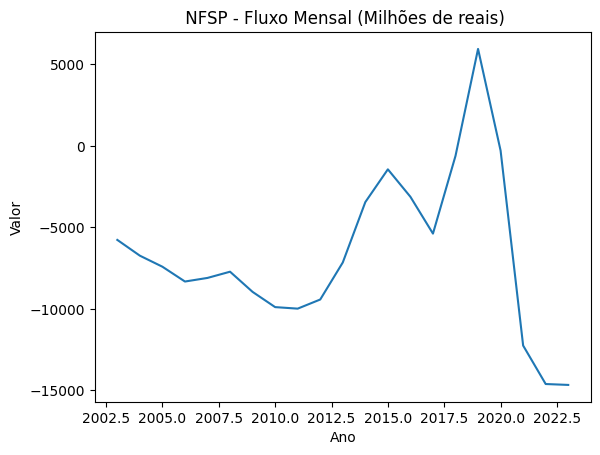

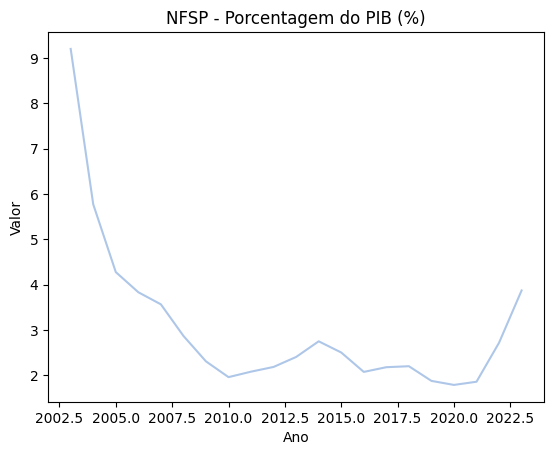

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
2003,-5772.701344,9.199031
2004,-6740.393737,5.770455
2005,-7417.815574,4.275691
2006,-8326.283951,3.830878
2007,-8104.868208,3.564317
2008,-7723.574973,2.868108
2009,-8961.781709,2.305885
2010,-9895.682385,1.958246
2011,-9989.170714,2.079088


In [9]:
df_2003 = df_ano[df_ano.index >= 2003]
plot_columns(df_2003)
df_2003

In [10]:
df_2003.to_csv("2003_01_nfsp.csv", index=True)

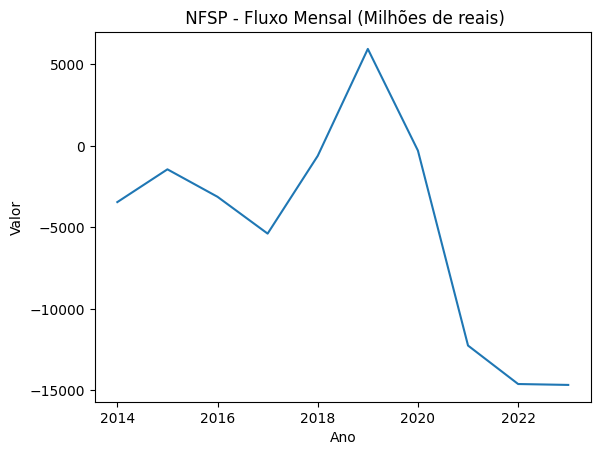

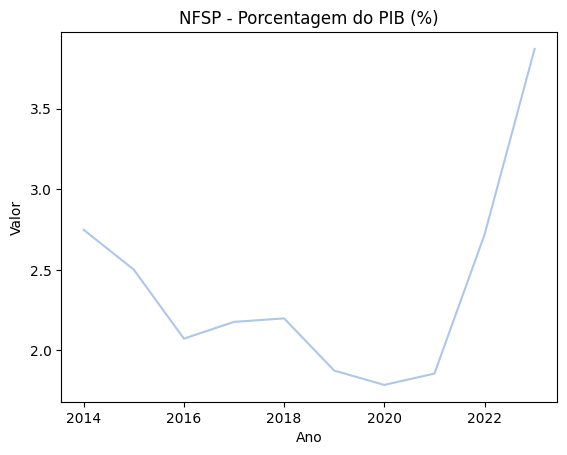

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
2014,-3453.461327,2.748397
2015,-1442.919387,2.501529
2016,-3128.377228,2.073464
2017,-5386.337108,2.177386
2018,-617.895763,2.199103
2019,5943.684500,1.875263
2020,-295.415924,1.786408
2021,-12254.220164,1.856764
2022,-14613.924468,2.717706


In [9]:
df_2014 = df_ano[df_ano.index >= 2014]
plot_columns(df_2014)
df_2014

In [10]:
df_2014.to_csv("2014_01_nfsp.csv", index=True)

In [10]:
df_2008 = df_ano[df_ano.index >= 2008]
df_2008

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%)
Ano,,
2008,-7723.574973,2.868108
2009,-8961.781709,2.305885
2010,-9895.682385,1.958246
2011,-9989.170714,2.079088
2012,-9429.326328,2.183282
2013,-7157.441850,2.403445
2014,-3453.461327,2.748397
2015,-1442.919387,2.501529
2016,-3128.377228,2.073464


In [11]:
df_2008.to_csv("2008_01_nfsp.csv", index=True)